<a href="https://colab.research.google.com/github/nebuus/fun/blob/extra/Reaction_diffusion_Cole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [199]:
# Importing stuffs

In [200]:
%matplotlib inline

In [185]:
%matplotlib inline
%matplotlib notebook
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import matplotlib.animation as animation  # this is needed for the animation API
import matplotlib.image as mpimg # for grayscale input image
from matplotlib.colors import Normalize   # this is needed to rescale the color during the simulation

In [186]:
# Discrete Laplacian part

In [187]:
A = np.ones((3,3))
A[1,1] = 0
A

array([[1., 1., 1.],
       [1., 0., 1.],
       [1., 1., 1.]])

In [188]:
right_neighbor = np.roll(A, # the matrix to permute
                         (0,-1), # we want the right neighbor, so we shift the whole matrix -1 in the x-direction)
                         (0,1), # apply this in directions (y,x)
                        )
right_neighbor

array([[1., 1., 1.],
       [0., 1., 1.],
       [1., 1., 1.]])

In [189]:
def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0, 1), (0, 1))  # right neighbor
    L += np.roll(M, (0, -1), (0, 1))  # left neighbor
    L += np.roll(M, (-1, 0), (0, 1))  # top neighbor
    L += np.roll(M, (1, 0), (0, 1))  # bottom neighbor

    return L

In [190]:
discrete_laplacian(A)

array([[ 0., -1.,  0.],
       [-1.,  4., -1.],
       [ 0., -1.,  0.]])

In [191]:
# Defining functions

In [225]:
def gray_scott_update(A, B, DA, DB, f, k, delta_t):
    """
    Updates a concentration configuration according to a Gray-Scott model
    with diffusion coefficients DA and DB, as well as feed rate f and
    kill rate k.
    """
    #A, B = torch.tensor(A.detach().cpu().numpy()), torch.tensor(B.detach().cpu().numpy())

    # Let's get the discrete Laplacians first
    LA = discrete_laplacian(A)
    LB = discrete_laplacian(B)

    # Now apply the update formula
    diff_A = (DA*LA - A*B**2 + f*(1-A)) * delta_t
    diff_B = (DB*LB + A*B**2 - (k+f)*B) * delta_t

    A += diff_A
    B += diff_B

    return A, B

In [193]:
def get_initial_configuration(N, random_influence=0.2):
    """
    Initialize a concentration configuration. N is the side length
    of the (N x N)-sized grid.
    `random_influence` describes how much noise is added.
    """

    # We start with a configuration where on every grid cell
    # there's a lot of chemical A, so the concentration is high
    A = (1-random_influence) * np.ones((N,N)) + random_influence * np.random.random((N,N))

    # Let's assume there's only a bit of B everywhere
    B = random_influence * np.random.random((N,N))

    # Now let's add a disturbance in the center
    N2 = N//2
    radius = r = int(N/10.0)

    A[N2-r:N2+r, N2-r:N2+r] = 0.50
    B[N2-r:N2+r, N2-r:N2+r] = 0.25

    return A, B

In [194]:
def draw(A,B):
    """draw the concentrations"""
    pl.clf()
    fig, ax = pl.subplots(1,2,figsize=(5.65,4))
    ax[0].imshow(A, cmap='Greys')
    ax[1].imshow(B, cmap='Greys')
    ax[0].set_title('A')
    ax[1].set_title('B')
    ax[0].axis('off')
    ax[1].axis('off')

    pl.show()

In [195]:
# The cool part

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

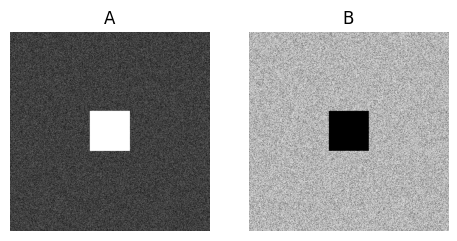

In [201]:
A, B = get_initial_configuration(741)
draw(A,B)

In [202]:
# update in time
delta_t = 1.0

# Diffusion coefficients
DA = 0.14
DB = 0.06

# define feed/kill rates
f = 0.040
k = 0.062

# grid size
N = 741

# simulation steps
N_simulation_steps = 10000

In [213]:
A, B = get_initial_configuration(741)

for t in range(N_simulation_steps):
    A, B = gray_scott_update(A, B, DA, DB, f, k, delta_t)

draw(A,B)

KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

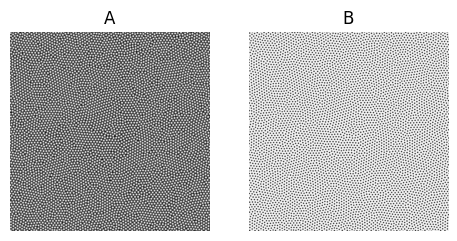

In [204]:
DA, DB, f, k = 0.14, 0.06, 0.035, 0.065 # bacteria
A, B = get_initial_configuration(741)

for t in range(N_simulation_steps):
    A, B = gray_scott_update(A, B, DA, DB, f, k, delta_t)

draw(A,B)

<Figure size 640x480 with 0 Axes>

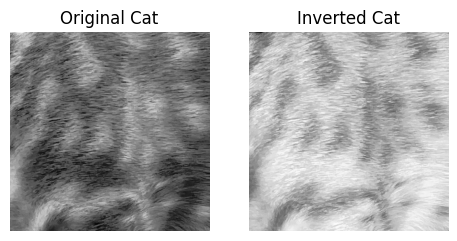

In [205]:
# importing pic, turning it grayscale and plotting it
from skimage import io
img = io.imread('/content/cut1.jpg', as_gray=True)
inverted_img = 1 - img
pl.clf()
fig, ax = pl.subplots(1,2,figsize=(5.65,4))
ax[0].imshow(img, cmap='Greys')
ax[0].set_title('Original Cat')
ax[0].axis('off')
ax[1].imshow(inverted_img, cmap='Greys')
ax[1].set_title('Inverted Cat')
ax[1].axis('off')
pl.show()

In [206]:
# Neural net part

In [221]:
class GrayScottModel(nn.Module):
    def __init__(self):
        super(GrayScottModel, self).__init__()
        # Define learnable parameters
        self.DA = nn.Parameter(torch.tensor(0.14))
        self.DB = nn.Parameter(torch.tensor(0.06))
        self.f = nn.Parameter(torch.tensor(0.035))
        self.k = nn.Parameter(torch.tensor(0.065))

    def forward(self, A, N_simulation_steps, delta_t):
        # Perform gray-scott simulation
        B = torch.zeros_like(A)
        for _ in range(N_simulation_steps):
            A, B = gray_scott_update(A, B, self.DA, self.DB, self.f, self.k, delta_t)

        return A, B

In [217]:
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
model = GrayScottModel()

criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

N_simulation_steps = 10000  # Adjust as needed
delta_t = 1
num_epochs = 1000

In [228]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Get the initial configuration
    A_init, B_init = get_initial_configuration(741)
    A_init_tensor, B_init_tensor = torch.tensor(A_init, dtype=torch.float32, requires_grad=True).unsqueeze(0).unsqueeze(0), torch.tensor(B_init, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Forward pass
    output_A, _ = model(A_init_tensor, N_simulation_steps, delta_t)
    output_A = output_A.detach().numpy()

    # Compute loss
    loss = criterion(output_A.squeeze(), img_tensor.squeeze())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


RuntimeError: ignored

In [ ]:
# Get the optimized parameters
DA_optimized, DB_optimized, f_optimized, k_optimized = model.DA.item(), model.DB.item(), model.f.item(), model.k.item()
print(f'Optimized Parameters: DA={DA_optimized}, DB={DB_optimized}, f={f_optimized}, k={k_optimized}')

In [ ]:
# Animation part

In [ ]:
def get_artists(A,B):
    """draw the concentrations"""
    fig, ax = pl.subplots(1,2,figsize=(5.65,3))
    imA = ax[0].imshow(A, animated=True, cmap='Greys')
    imB = ax[1].imshow(B, animated=True, cmap='Greys')
    ax[0].set_title('A')
    ax[1].set_title('B')
    ax[0].axis('off')
    ax[1].axis('off')

    return fig, imA, imB

In [ ]:
def updatefig(frame_id,updates_per_frame,A,B,DA,DB,f,k,delta_t):
    """Takes care of the matplotlib-artist update in the animation"""
    global imA, imB

    # update x times before updating the frame
    for u in range(updates_per_frame):
        A, B = gray_scott_update(A,B,DA,DB,f,k,delta_t)

    # update the frame
    imA.set_array(A)
    imB.set_array(B)

    # renormalize the colors
    imA.set_norm(Normalize(vmin=np.amin(A),vmax=np.amax(A)))
    imB.set_norm(Normalize(vmin=np.amin(B),vmax=np.amax(B)))

    # return the updated matplotlib objects
    return imA, imB

In [ ]:
# Diffusion coefficients
DA = 0.08
DB = 0.04

# define feed/kill rates
f = 0.001480
k = 0.004644

N_simulation_steps = 3000

# intialize the figures
A, B = get_initial_configuration(N)
fig, imA, imB = get_artists(A, B)

# how many updates should be computed before a new frame is drawn
updates_per_frame = 10

# these are the arguments which have to passed to the update function
animation_arguments = (updates_per_frame, A, B, DA, DB, f, k, delta_t)

# let's make sure we can see the animation in the notebook
from IPython.display import HTML
mpl.rcParams['animation.html'] = 'html5'
#mpl.rcParams['animation.embed_limit'] = 1024 # this allows jupyter notebook to save 1024MB video data in the memory


# start the animation
ani = animation.FuncAnimation(fig, #matplotlib figure
                              updatefig, # function that takes care of the update
                              fargs=animation_arguments, # arguments to pass to this function
                              interval=10, # update every `interval` milliseconds
                              frames=int(N_simulation_steps/updates_per_frame), #limit the number of frames
                              blit=True, # optimize the drawing update
                              )

HTML(ani.to_html5_video())